# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import sdf
import re
import glob, os
import tqdm
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)


# Parameters

## Physical Constants

In [2]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12

## Constants From Simulation

In [3]:
DATA_DIR = "run1"
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

The parameters which we want to extract are:
* Wavelength: `lambda`
* Laser Time: `las_time`
* Vector Potential: `a0`
* The density factor: `factor`
* Number of Cells: `nx`
* Simulation End Time: `t_end`
* Size of Box: `x_min`
* dt: `dt_snapshot`

In [4]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [5]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("t_end"))
DT = find_value("dt_snapshot")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("nx"))
X_MIN = -int(find_value("x_min"))

print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("x_min = ", X_MIN)

Values from input.deck:
lambda0 =  1e-06
laser_time =  20
t_end =  40
dt_snapshot =  8e-17
a0 =  1.0
factor =  3
nx =  16000
x_min =  -20


## Calculated Constants

In [6]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
print("Calculated Values for the simulation are:")
print("omega0 = ", omega0)
print("tau = ", tau)
print("nc = ", nc)
print("Er = ", Er)
print("n0 = ", n0)

Calculated Values for the simulation are:
omega0 =  1883651567308853.2
tau =  3.3356409519815205e-15
nc =  1.1143269197457677e+27
Er =  3210701072782.3525
n0 =  3.342980759237303e+27


## Values for FT

In [7]:
omega_to_resolve = 20*omega0
f_max_to_resolve = omega_to_resolve/(2*PI)
dt_max_to_resolve = 1/(2*f_max_to_resolve)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15} femto seconds")

The maximum time step for resolution is 0.08339102379953801 femto seconds


In [8]:
f_max = 1/(DT)
omega_max = 2*np.pi*f_max
omega_max/omega0

41.69551189976901

## Other Variables

In [9]:
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
len(ALL_FILES)

1669

In [10]:
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

# Plots

In [53]:
data = sdf.read(ALL_FILES[100])

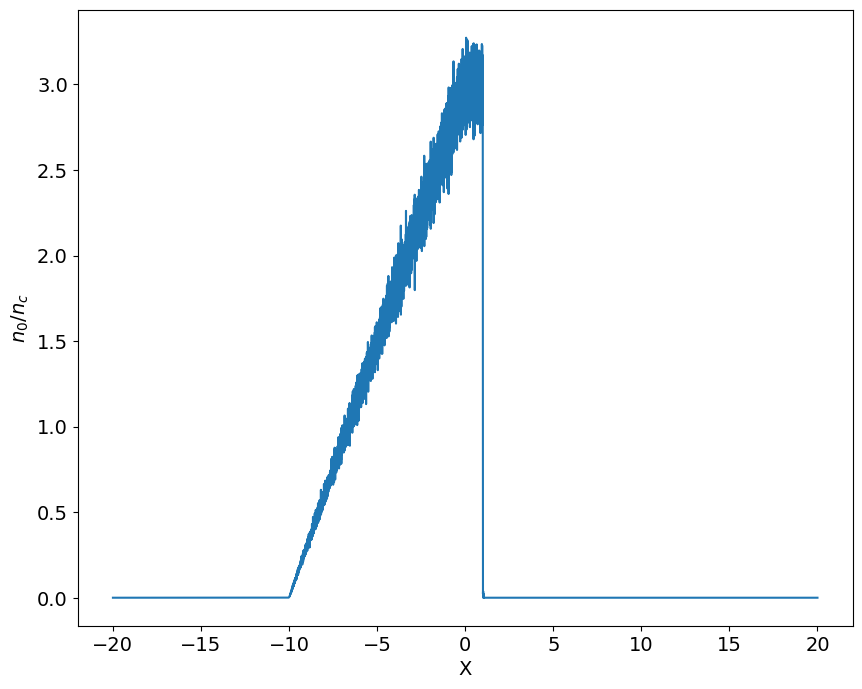

In [54]:
plt.plot(X, data.Derived_Number_Density_Electron.data/nc)
plt.xlabel("X")
plt.ylabel("$n_0/n_c$");

In [55]:
def get_field(id, component="y"):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x": raw_data.Electric_Field_Ex,
        "y": raw_data.Electric_Field_Ey,
        "z": raw_data.Electric_Field_Ez,
    }
    field = comp[component].data
    return field


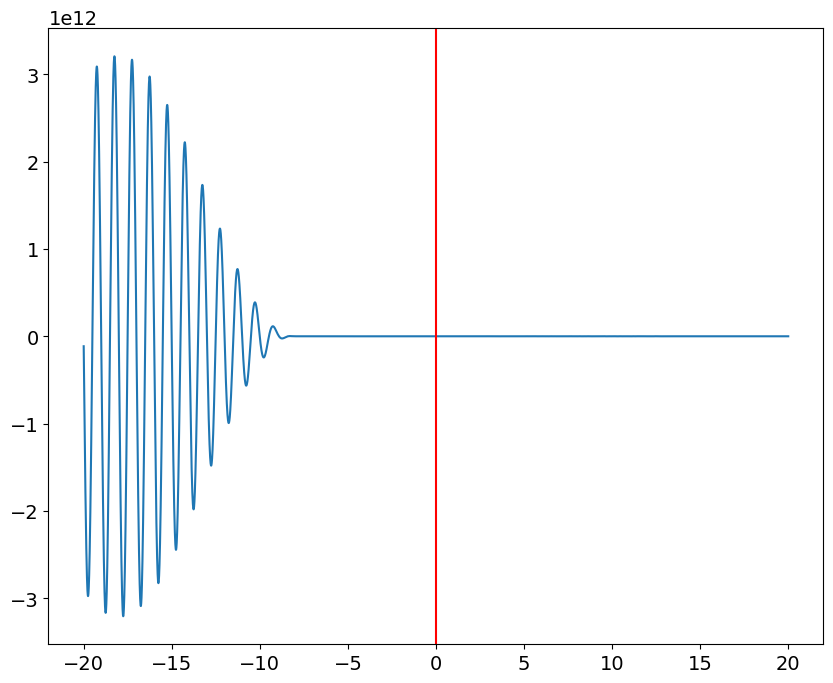

In [56]:
Ey = get_field(500)
plt.plot(X, Ey)
plt.axvline(0, color="red")
plt.show()


In [57]:
Et0 = np.zeros(len(ALL_FILES))
Et1 = np.zeros(len(ALL_FILES))
Et2 = np.zeros(len(ALL_FILES))
d = np.zeros((len(ALL_FILES), NX))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Et0[i] = ey[0]
    Et1[i] = ey[4000]
    Et2[i] = ey[8000]
    d[i] = data.Derived_Number_Density_Electron.data


Getting Data...: 100%|██████████| 1669/1669 [00:04<00:00, 336.21it/s]


In [58]:
d.shape, Et0.shape

((1669, 16000), (1669,))

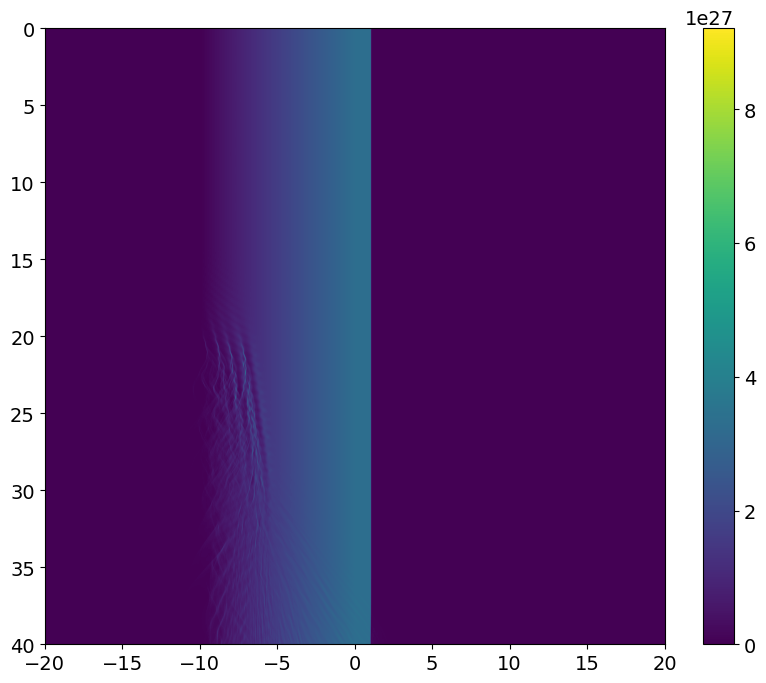

In [59]:
EXTENT = [X_MIN,-X_MIN,T_MAX,0]
plt.imshow(d, aspect="auto", extent=EXTENT)
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

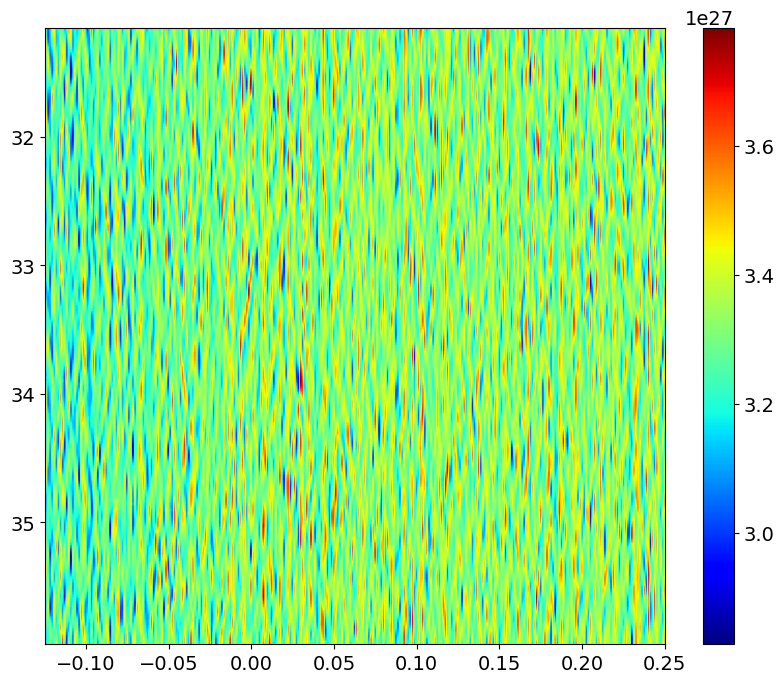

In [60]:
t_start = 1300
t_end = 1500
t_max = d.shape[0]
x_max = d.shape[1]
x_start = 2*3950
x_end = 2*4100
EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet")
cmap = colors.ListedColormap(["white", "black"])
plt.colorbar(cmap=cmap)

## FT

In [61]:
y0 = np.fft.fft(Et0)
y3 = np.fft.fft(Et1)
y4 = np.fft.fft(Et2)

In [68]:
y0_shift = np.fft.fftshift(y0)
y3_shift = np.fft.fftshift(y3)
y4_shift = np.fft.fftshift(y4)
y0_f = np.abs(y0_shift)
y3_f = np.abs(y3_shift)
y4_f = np.abs(y4_shift)
y0_f = y0_f/np.max(y0_f)
y3_f = y3_f/np.max(y3_f)
y4_f = y4_f/np.max(y4_f)

In [69]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

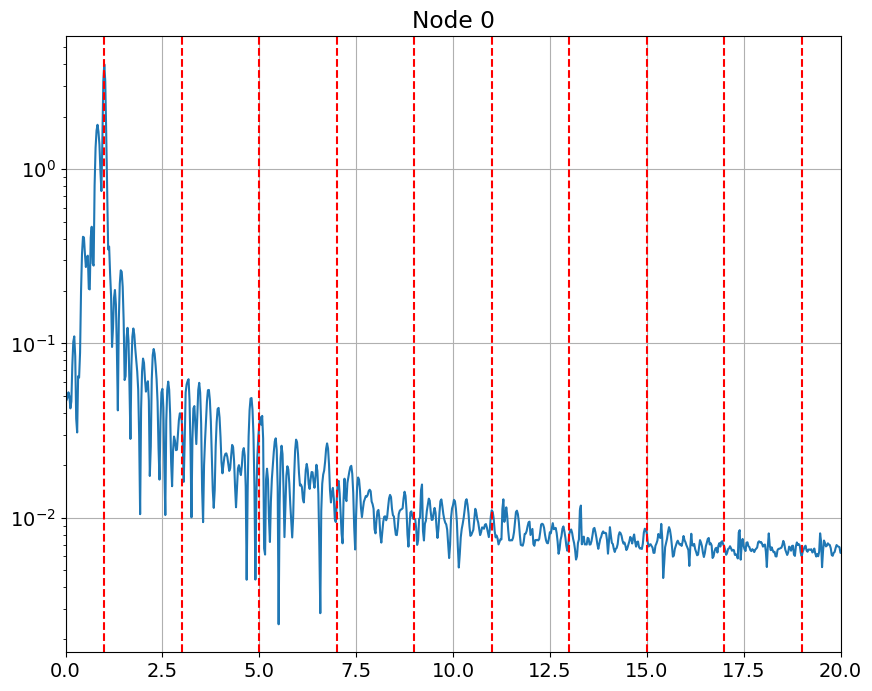

In [75]:
plt.plot(omega/omega0, 2*np.abs(y0_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    # plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.title("Node 0");

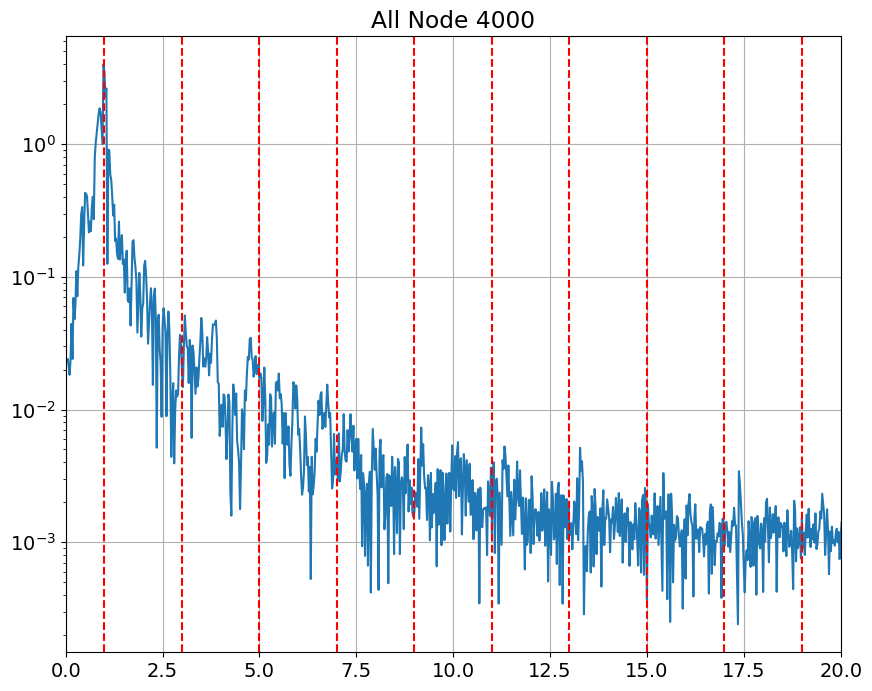

In [74]:
plt.plot(omega/omega0, 2*np.abs(y3_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    # plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
plt.grid()
plt.title("All Node 4000");

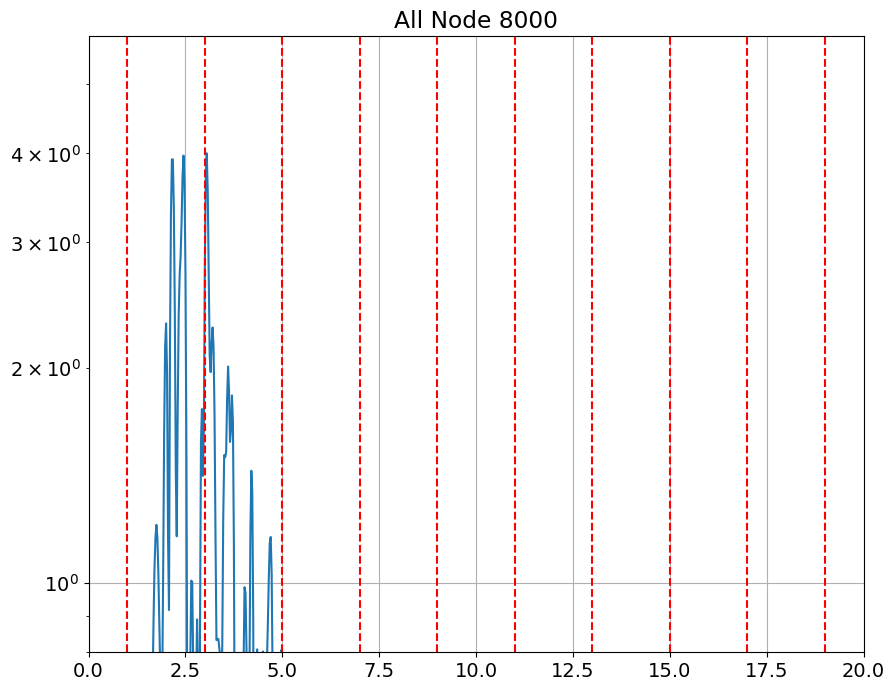

In [73]:
plt.plot(omega/omega0, 2*np.abs(y4_f)*2)
plt.yscale("log")
points = np.arange(1,21,2)
for p in points:
    plt.axvline(p, color="red", linestyle="--")
    # plt.annotate(f"{p}", (p, 1e-2))
plt.xlim(0,20)
# plt.ylim(0.8)
plt.grid()
plt.title("All Node 8000");

In [11]:
Eys = np.zeros((len(ALL_FILES), NX))
for i in tqdm.tqdm(range(len(ALL_FILES)), desc="Getting Data..."):
    data = sdf.read(ALL_FILES[i])
    ey = data.Electric_Field_Ey.data
    Eys[i] = ey

Getting Data...: 100%|██████████| 1669/1669 [00:01<00:00, 881.93it/s] 


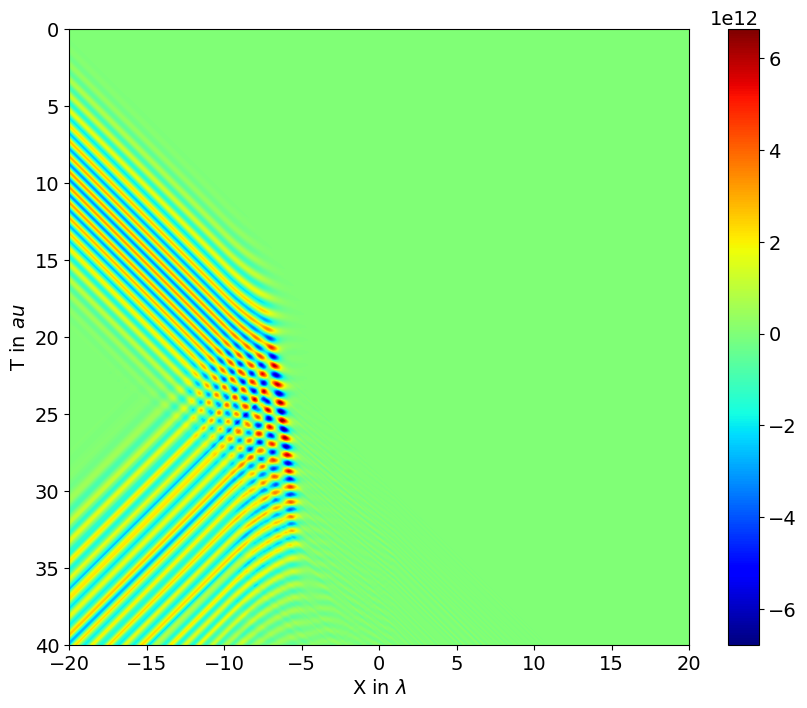

In [12]:
extent = [X_MIN, -X_MIN, T_MAX, 0]
plt.imshow(Eys, aspect="auto", extent=extent, cmap="jet")
plt.xlabel("X in $\lambda$")
plt.ylabel("T in $\tau$")
plt.colorbar();

In [13]:
def plot_one_e_fileld(id_, ax):
    raw_data = sdf.read(ALL_FILES[id_])
    ey = raw_data.Electric_Field_Ey.data
    ey = ey/np.max(ey)
    time = raw_data.Header['time']
    ax.plot(X, ey)
    ax.set_xlabel("X")
    ax.set_ylabel("$E_y$")
    ax.set_title(f"t = {time*1e15:.2f} fs")

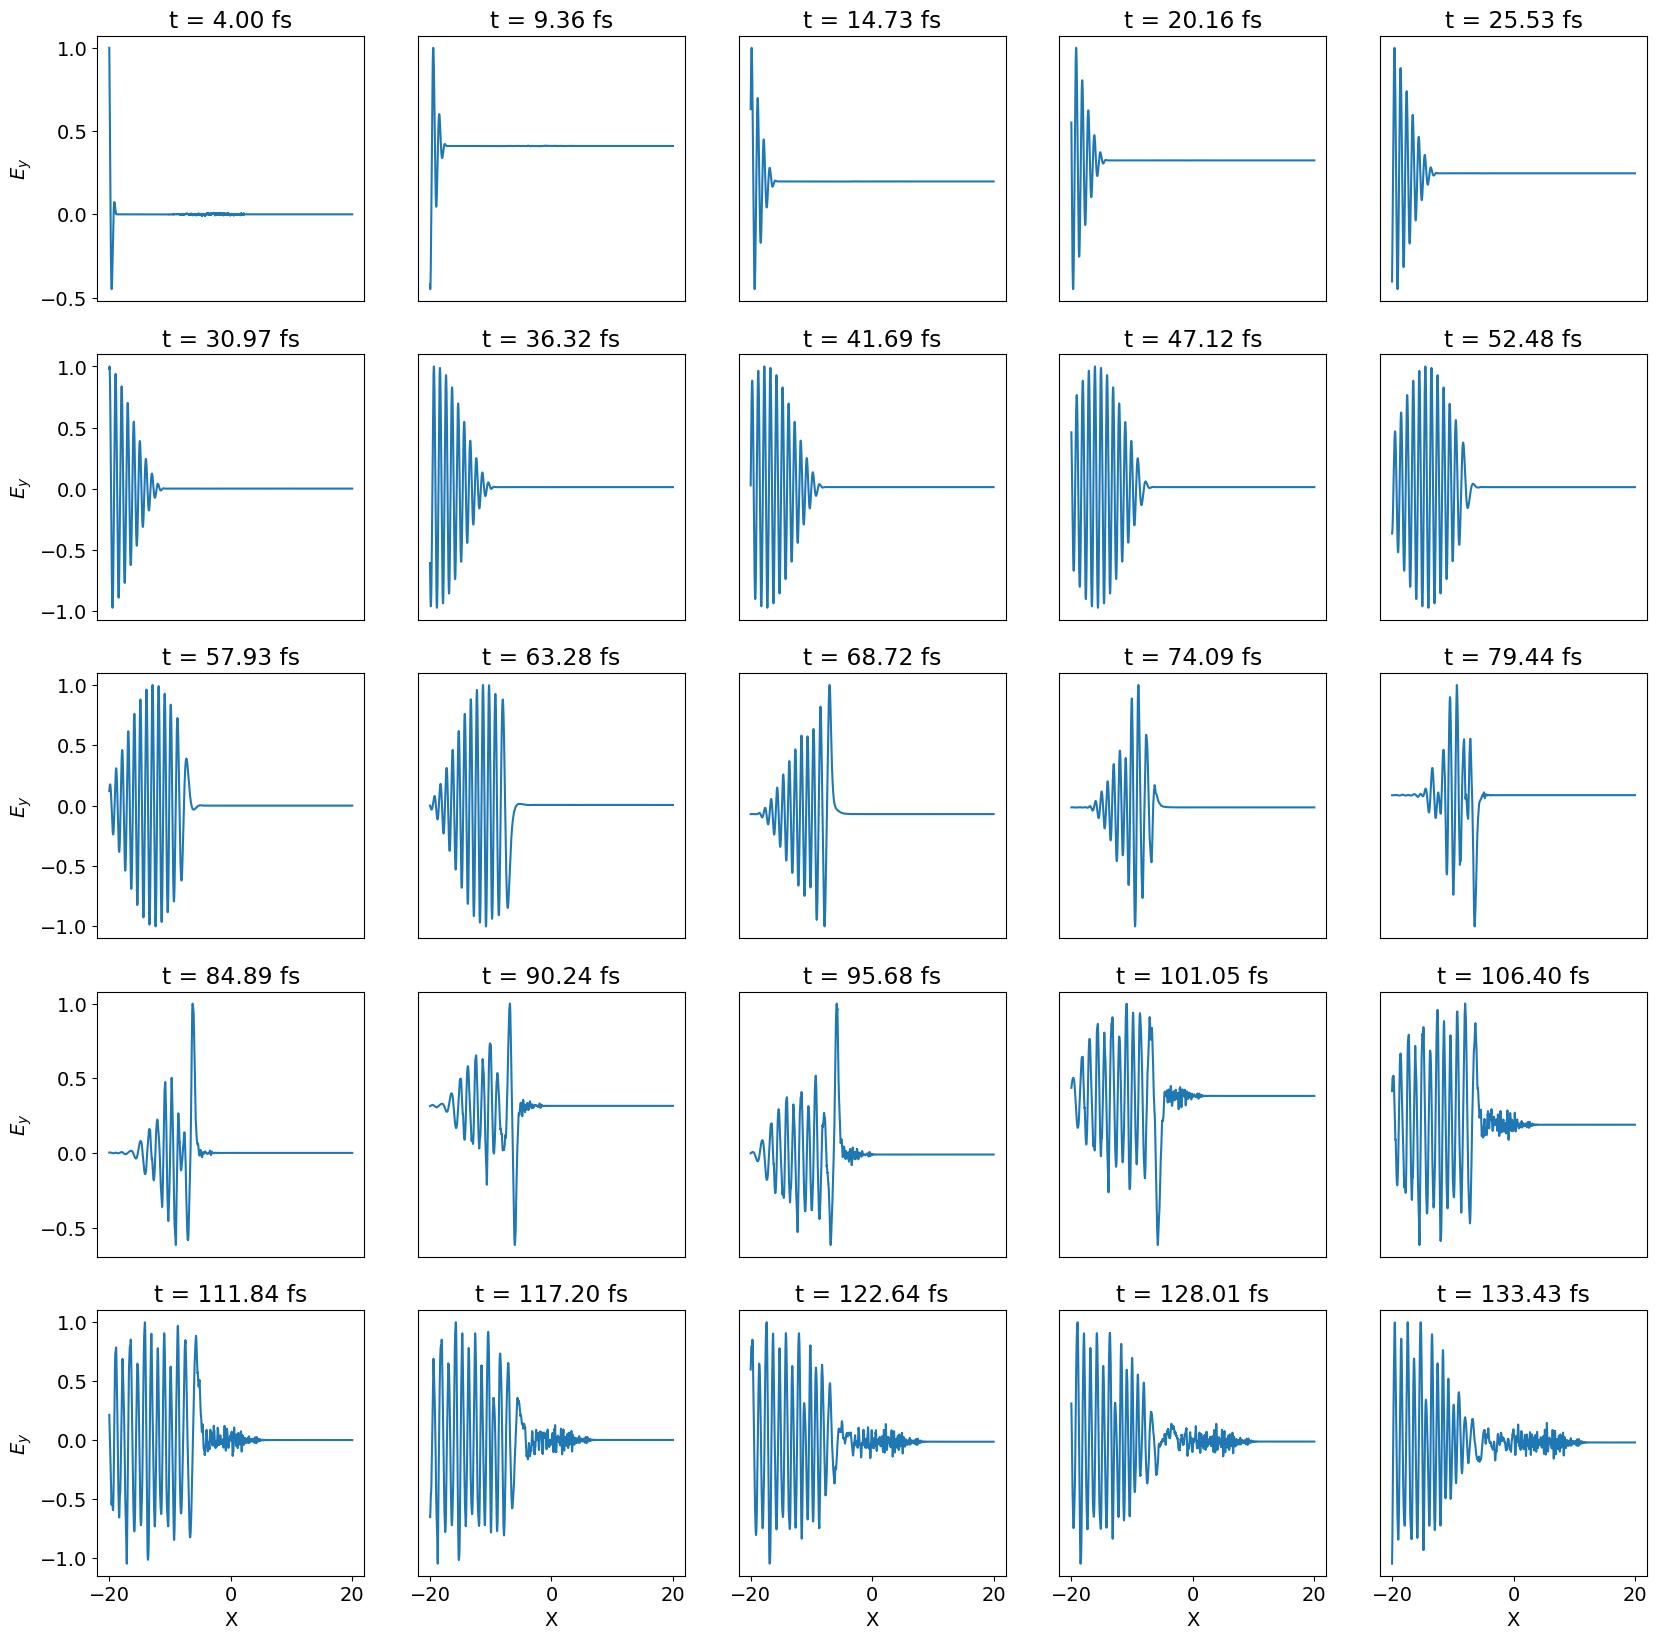

In [14]:
figs = 25
n = int(np.sqrt(figs))
fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))
ids = np.linspace(50, len(ALL_FILES)-1, figs).astype(int)
for i, ax in enumerate(axes.flatten()):
    plot_one_e_fileld(ids[i], ax)
    if i<figs-n:
        ax.set_xticks([])
        ax.set_xlabel("")
    if i%n>0:
        ax.set_yticks([])
        ax.set_ylabel("")

In [21]:
def plot_fft(Ey, omegas, lines=False, xlim=(0, 20), ylim=None, fig_name=None):
    Ey_fft = np.fft.fft(Ey)
    Ey_fft = np.fft.fftshift(Ey_fft)
    Ey_fft = np.abs(Ey_fft)
    Ey_fft = Ey_fft / Ey_fft.max()
    plt.figure()
    plt.plot(omegas, Ey_fft)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.yscale("log")
    points = np.arange(1, 21, 2)
    if lines:
        for point in points:
            plt.axvline(point, color="red", linestyle="--")
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(points)


In [22]:
omega = np.linspace(-omega_max/2, omega_max/2, len(ALL_FILES))

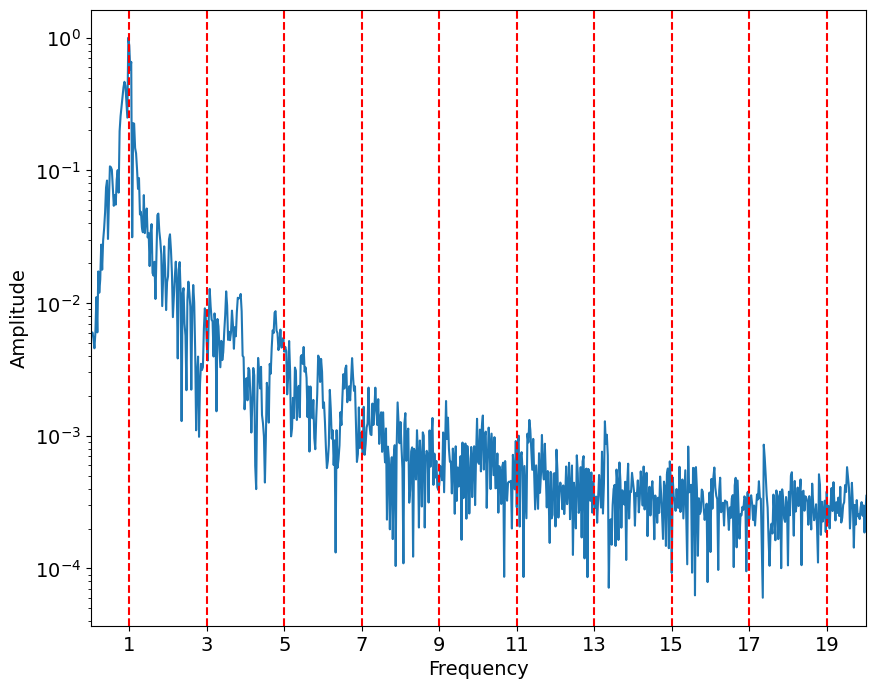

In [24]:
plot_fft(Eys[:, 4000], omega/omega0, lines=True)